In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
import torch.nn.functional as F
from tqdm.auto import tqdm
from sklearn import metrics
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import sys
from sklearn.preprocessing import StandardScaler,MinMaxScaler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
device = DEVICE
print(DEVICE)

cpu


In [128]:
sns.set(font_scale=1.5)

X1 = np.random.uniform(-10, 10,6000)
X2 = np.random.uniform(-20, 20,6000)
X3 = np.random.uniform(-300, 300,6000)
X4 = np.random.uniform(-5, 5, 6000)

#x1 = np.linspace(-10, 10, 100)
#x2 = np.linspace(-10, 10, 100)
#data = []
#for xx1 in x1:
#  for xx2 in x2:
#    data.append([xx1, xx2])
#data = np.array(data)
#np.random.shuffle(data)
#print(data)
#X1 = data[:,0]
#X2 = data[:,1]

y = 3*X1 ** 3 - 4 * X1 ** 2 + 5 * X1 - 6 - X2 ** 2 + 0.1 * X2 + X3 - 2 * X4 ** 3 - 7 * X4 + 6 * X1 * X2 - 3 * X1 * X4 + np.random.randn(6000) * 600
#y = 3*X1 ** 3 - 4 * X1 ** 2 + 5 * X1 - 6 - 4 * X2 ** 2 + 6 * X1 * X2 + np.random.randn(6000) * 60

#X = np.array([X1, X2, X3, X4]).transpose()
X = np.array([X1, X2, X3, X4]).transpose()
trans = StandardScaler()
X = trans.fit_transform(X)
y

array([ -345.46690885,   325.11392965,   514.50583586, ...,
        -563.68385546, -2139.61938445, -1598.42742305])

<ipython-input-129-a420c59d6f25>:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, hist=True, kde=False,


Text(0, 0.5, 'Flights')

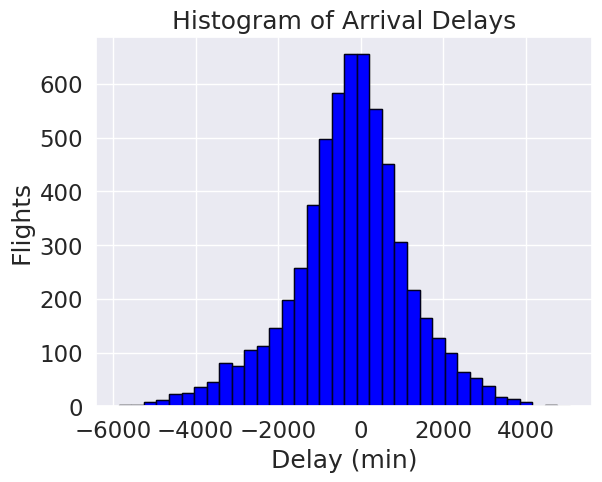

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

levels = np.linspace(y.min(), y.max(), 7)

# matplotlib histogram
plt.hist(y, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# seaborn histogram
sns.distplot(y, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Arrival Delays')
plt.xlabel('Delay (min)')
plt.ylabel('Flights')

In [130]:
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

batch = 32

train_loader = DataLoader(train_dataset, batch_size=batch)
val_loader = DataLoader(val_dataset, batch_size=batch)

<ipython-input-130-307631c7bca7>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
<ipython-input-130-307631c7bca7>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))


In [141]:
class LinearModel(nn.Module):
  def __init__(self, in_features, out_features):
    super(LinearModel, self).__init__()

    self.lin_linear_1 = self.make_layer(in_features, in_features * 5*4*4)
    self.lin_linear_2 = self.make_layer(in_features * 5*4*4, in_features * 10*4*4)
    self.lin_linear_3 = self.make_layer(in_features * 10*4*4, in_features * 5*4*4)
    self.lin_linear_4 = self.make_layer(in_features * 5*4*4, out_features)
    self.dropout = nn.Dropout(0.35)
    self.relu = nn.LeakyReLU(0.15)

  def make_layer(self, in_f, out_f):
    return nn.Linear(in_f, out_f)

  def forward(self, x):
    x = self.relu(self.lin_linear_1(x))
    #x = self.dropout(x)  # Применение Dropout после каждого слоя и активации
    x = self.relu(self.lin_linear_2(x))
    #x = self.dropout(x)
    x = self.relu(self.lin_linear_3(x))
    #x = self.dropout(x)
    x = self.lin_linear_4(x)
    return x

In [142]:
model = LinearModel(4, 1)

In [143]:
# Коэффициент скорости обучения. При большом значении результат будет "скакать". При малом - длительное время оптимизации.
learnRate = 0.00003
# Выбор оптимизатора.
optimiser =  optim.Adam(model.parameters(), lr =learnRate)
#optimiser =  optim.Adadelta(model.parameters())
#optimiser =  optim.RMSprop(model.parameters(), lr =learnRate)
# Выбор критерия оценки потерь.
criterion = nn.MSELoss()
# Количество циклов - эпох
epochs = 500

In [144]:
train_loss_history = []
test_loss_history = []
r2_history = []
mase_history = []
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), mase_history, c="red", label="MASE")
plt.xlabel("Epoch")
plt.ylabel("MASE")
plt.legend();


for epoch in tqdm(range(epochs)):

    train_loss = 0.0
    test_loss = 0.0
    r2 = 0.0
    mase = 0
    model.train()
    for X_batch, y_batch in train_loader:

      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      model.zero_grad()
      predicted_values = model(X_batch).squeeze(1)

      loss = criterion(predicted_values, y_batch)
      loss.backward()
      optimiser.step()

      train_loss += loss.item()

    train_loss /= len(train_loader)
    train_loss_history.append(train_loss)
    with torch.no_grad():
      model.eval()
      for X_test_batch, y_test_batch in val_loader:

        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        naive_predictions = torch.mean(torch.abs(y_test_batch - torch.mean(y_test_batch)))
        test_predictions = model(X_test_batch).squeeze(1)

        test_loss += criterion(test_predictions, y_test_batch).item()

        d1 = y_test_batch - test_predictions
        d2 = y_test_batch - y_test_batch.mean()
        r2 = 1 - d1.dot(d1) / d2.dot(d2) # коэффициент детерминации. должен быть в интервале от 0.75 до 1

        absolute_error = torch.mean(torch.abs(y_test_batch - test_predictions))
        mase += absolute_error / naive_predictions

    test_loss /= len(val_loader)
    test_loss_history.append(test_loss)
    r2_history.append(r2)
    mase /= len(val_loader)
    mase_history.append(mase)
    print(f"Epoch: {epoch} | Train loss: {train_loss} |  Test loss: {test_loss} |  R2: {r2} | MASE: {mase}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1995829.2779255318 |  Test loss: 2109053.168218085 |  R2: -0.0025899410247802734 | MASE: 1.032821774482727
Epoch: 1 | Train loss: 1990583.7054521276 |  Test loss: 2098622.6469414895 |  R2: 0.0027852654457092285 | MASE: 1.0300700664520264
Epoch: 2 | Train loss: 1973150.5352393617 |  Test loss: 2069915.326462766 |  R2: 0.017542898654937744 | MASE: 1.0224436521530151
Epoch: 3 | Train loss: 1934483.3982712766 |  Test loss: 2014622.7918882978 |  R2: 0.045863330364227295 | MASE: 1.0075896978378296
Epoch: 4 | Train loss: 1868179.2626329786 |  Test loss: 1927462.7220744682 |  R2: 0.09054738283157349 | MASE: 0.9839621186256409
Epoch: 5 | Train loss: 1771213.1841755318 |  Test loss: 1807482.4275265958 |  R2: 0.15228617191314697 | MASE: 0.951233983039856
Epoch: 6 | Train loss: 1645164.2074468085 |  Test loss: 1658964.5046542552 |  R2: 0.2292434573173523 | MASE: 0.9102626442909241
Epoch: 7 | Train loss: 1496765.7027925532 |  Test loss: 1491853.2021276595 |  R2: 0.31684118509

In [ ]:
Та же модель, что и для 2-х переменных

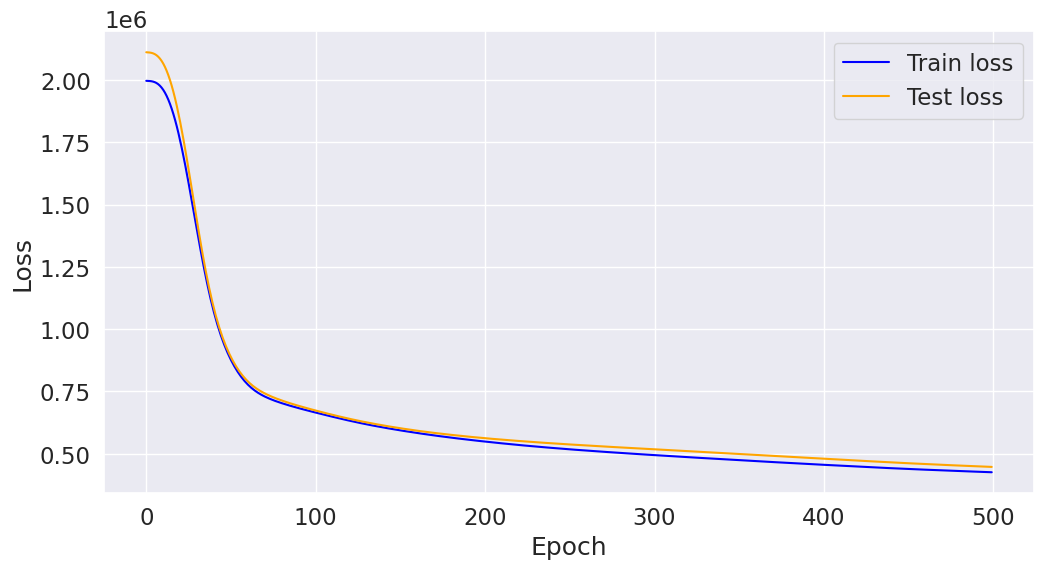

In [138]:
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_loss_history, c="blue", label="Train loss")
plt.plot(range(epochs), test_loss_history, c="orange", label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

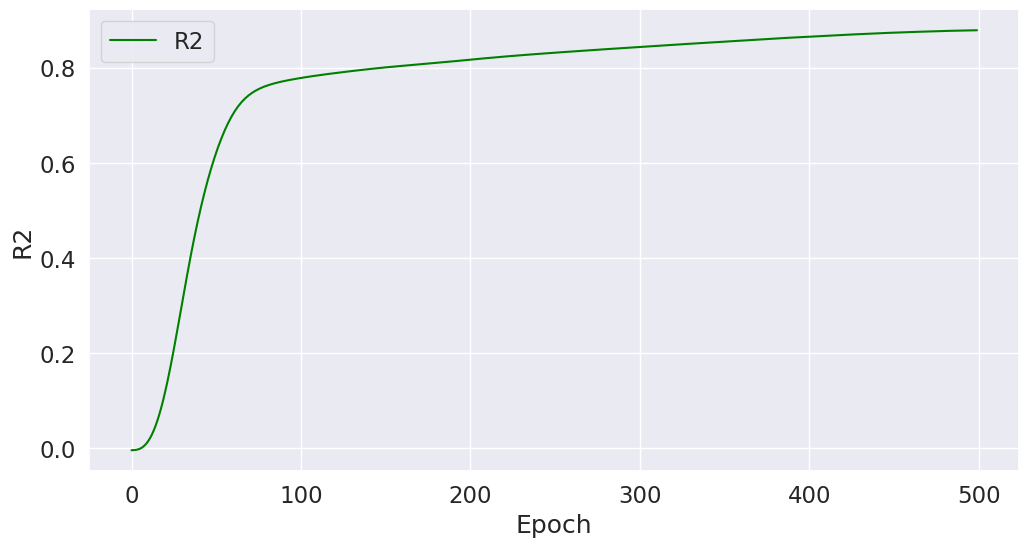

In [139]:
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), r2_history, c="green", label="R2")
plt.xlabel("Epoch")
plt.ylabel("R2")
plt.legend();

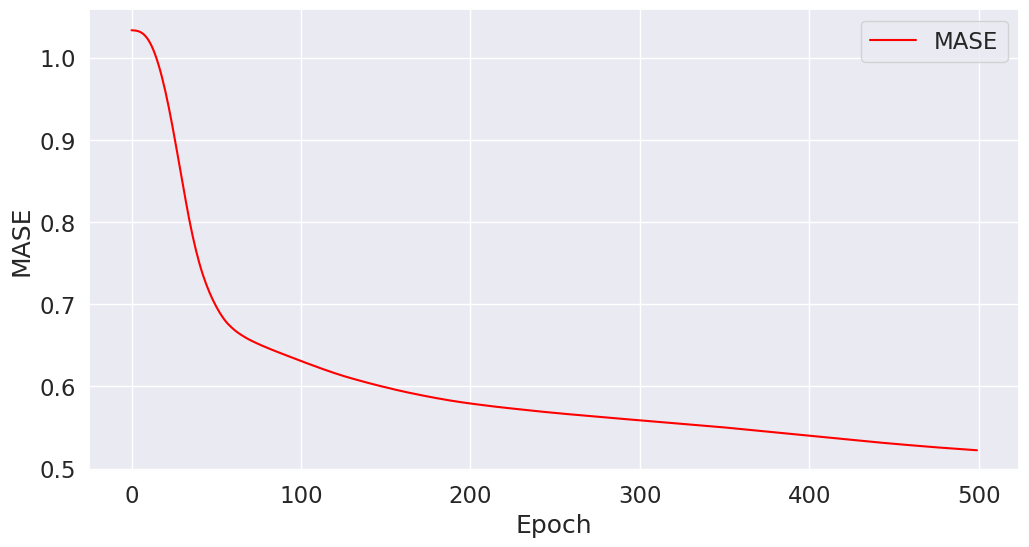

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), mase_history, c="red", label="MASE")
plt.xlabel("Epoch")
plt.ylabel("MASE")
plt.legend();

In [ ]:
Усложненная модель (в каждом слое в 4 раза больше нейронов)

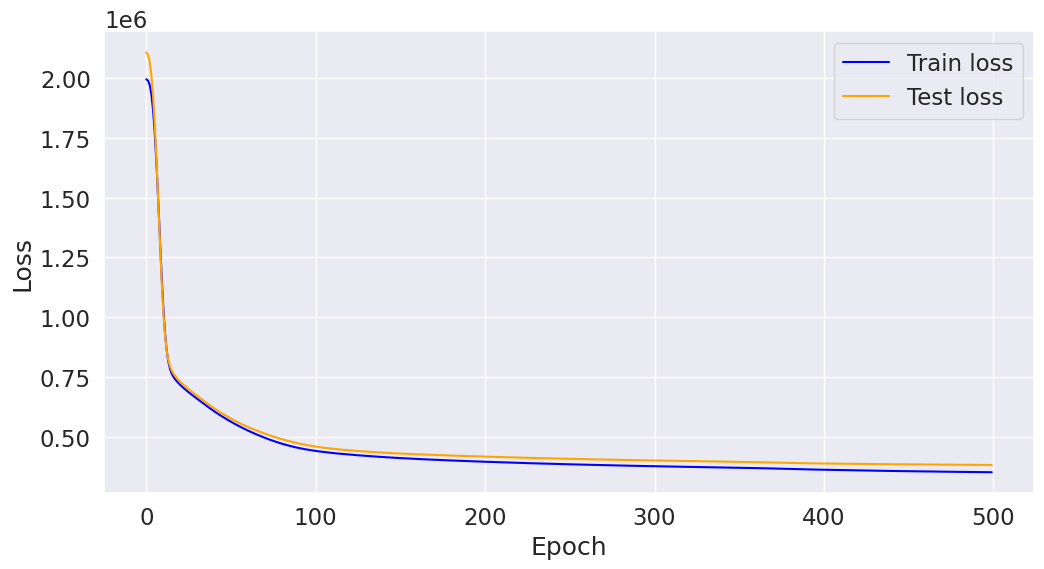

In [145]:
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), train_loss_history, c="blue", label="Train loss")
plt.plot(range(epochs), test_loss_history, c="orange", label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

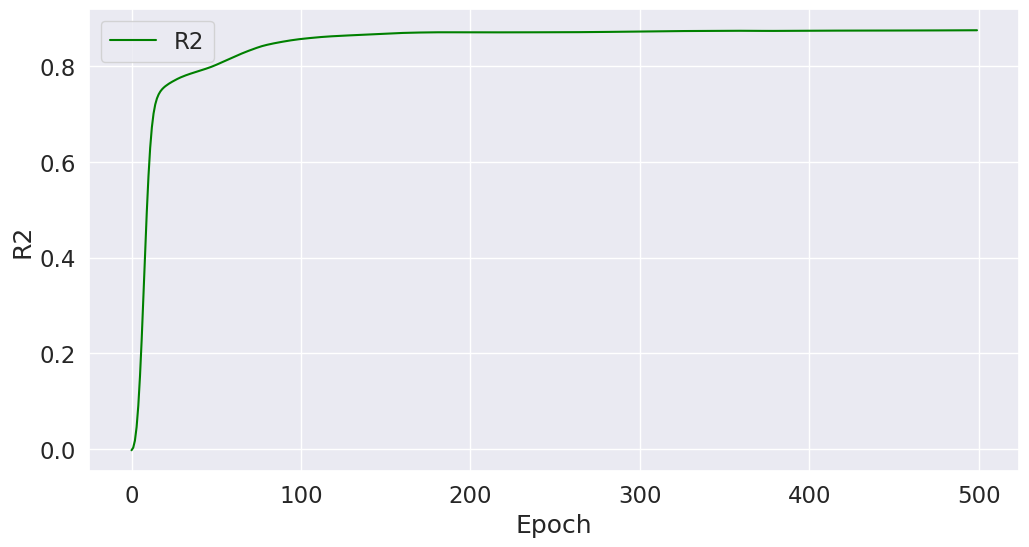

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), r2_history, c="green", label="R2")
plt.xlabel("Epoch")
plt.ylabel("R2")
plt.legend();

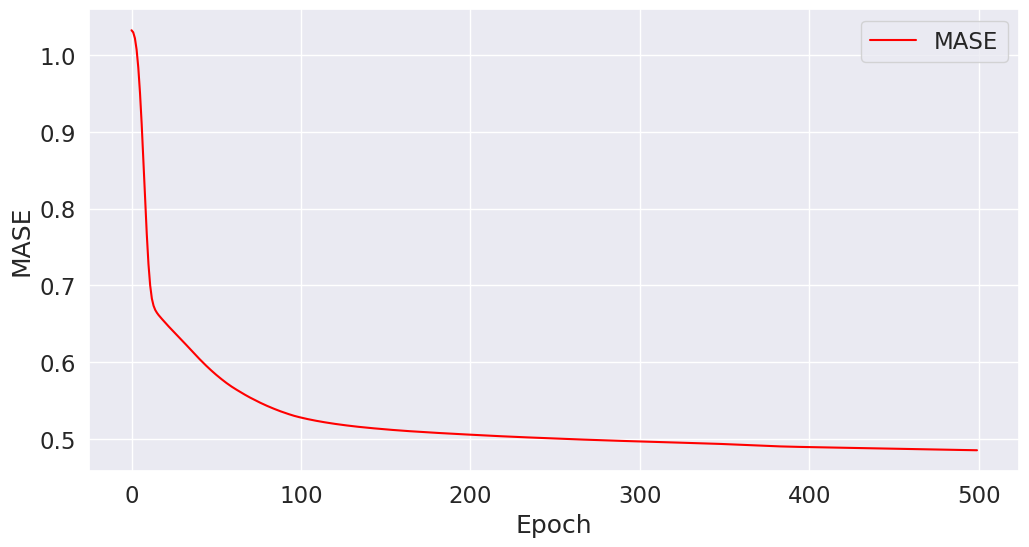

In [147]:
plt.figure(figsize=(12, 6))
plt.plot(range(epochs), mase_history, c="red", label="MASE")
plt.xlabel("Epoch")
plt.ylabel("MASE")
plt.legend();